# Introduction to CUDA Programming with CuPy

In this lab, we'll explore the fundamentals of GPU programming using CUDA through CuPy, a NumPy-compatible library for GPU-accelerated computing. We'll focus on understanding:

1. The basics of CUDA programming model
2. How to write and execute CUDA kernels
3. How to implement convolutional filters for image processing
4. Comparing CPU vs GPU performance

# Articles:

Read these articles first to better understand the topic

https://developer.nvidia.com/blog/easy-introduction-cuda-c-and-c/

https://developer.nvidia.com/blog/even-easier-introduction-cuda/

https://medium.com/@abhishekjainindore24/all-about-convolutions-kernels-features-in-cnn-c656616390a1

https://setosa.io/ev/image-kernels/

In [2]:
# %%
# Import necessary libraries
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import urllib.request
import os
import time

In [3]:
# Check if CUDA is available
try:
    print(f"CuPy CUDA version: {cp.cuda.runtime.runtimeGetVersion()}")
    print(f"Available GPU(s): {cp.cuda.runtime.getDeviceCount()}")
    print(f"Current device: {cp.cuda.runtime.getDevice()}")
    device_props = cp.cuda.runtime.getDeviceProperties(cp.cuda.runtime.getDevice())
    print(f"Device name: {device_props['name'].decode()}")
    print(f"Compute capability: {device_props['major']}.{device_props['minor']}")
    print(f"Total memory: {device_props['totalGlobalMem'] / (1024**3):.2f} GB")
    cuda_available = True
except:
    print("CUDA not available. Running in CPU-only mode.")
    cuda_available = False

CuPy CUDA version: 12080
Available GPU(s): 1
Current device: 0
Device name: NVIDIA GeForce RTX 2060
Compute capability: 7.5
Total memory: 5.61 GB


## Part 1: Understanding the CUDA Programming Model

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA. It enables developers to use NVIDIA GPUs for general-purpose processing.

Key concepts:

- **Host**: The CPU and its memory
- **Device**: The GPU and its memory
- **Kernel**: A function that runs on the GPU
- **Thread**: The smallest unit of execution in CUDA
- **Block**: A group of threads that can cooperate
- **Grid**: A group of blocks that execute the same kernel

The CUDA execution model is organized into a hierarchy:

1. Threads are grouped into blocks
2. Blocks are organized into a grid
3. Each thread has a unique ID within its block
4. Each block has a unique ID within the grid

This model allows for massive parallelism by executing thousands of threads simultaneously.

In [50]:
# %%
# Download sample image
img_url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
img_path = "example.jpg"

In [51]:
if not os.path.exists(img_path):
    urllib.request.urlretrieve(img_url, img_path)
    print("Image downloaded.")

In [52]:
# Load grayscale image
image = cv2.imread('example.jpg', cv2.IMREAD_GRAYSCALE)
image_np = image.astype(np.float32) / 255.0

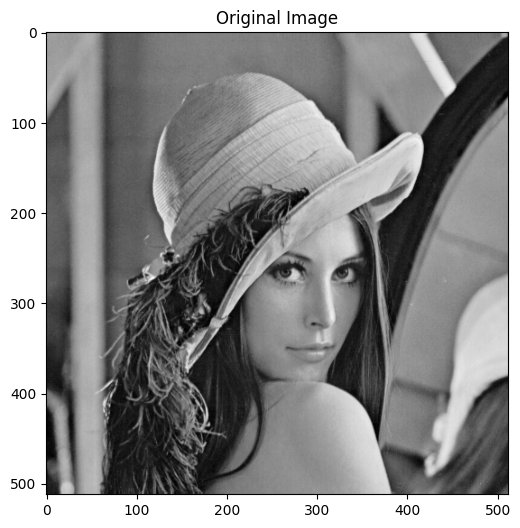

In [53]:
# Display the original image
plt.figure(figsize=(6, 6))
plt.title("Original Image")
plt.imshow(image_np, cmap='gray')
plt.show()

## Part 2: Implementing a Basic Edge Detection Filter

Before we dive into the details of CUDA programming, let's start with a simple example: applying an edge detection filter to our image. We'll define a single kernel (Sobel vertical edge detector) and implement it on both CPU and GPU to see the difference.

In [ ]:
# %%
# Define a simple edge detection kernel (Sobel vertical)
# @TODO
sobel_v = np.array([...], dtype=np.float32)

In [ ]:
print("Sobel Vertical Edge Detection Kernel:")
print(sobel_v)

### CPU Implementation

Let's first implement this filter on the CPU using NumPy.

In [56]:
# %%
def convolve_cpu(image, kernel):
    """
    Apply convolution to an image using CPU (NumPy).
    
    Args:
        image: 2D NumPy array
        kernel: 2D NumPy array
    
    Returns:
        Convolved image
    """
    # Get dimensions
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Pad the image
    # @TODO
    padded = np.pad(image, ((...), (...)), mode='constant')
    
    # Output array
    output = np.zeros_like(image)
    
    # Apply convolution
    for y in range(img_h):
        for x in range(img_w):
            # Extract the region of interest
            # @TODO
            region = padded[y:y+..., x:x+...]
            # Apply the kernel
            # @TODO
            output[y, x] = np.sum(... * ...)
    
    return output

In [57]:
# Test CPU convolution with our Sobel filter
start_time = time.time()
result_cpu = convolve_cpu(image_np, sobel_v)
cpu_time = time.time() - start_time
print(f"CPU convolution time: {cpu_time:.4f} seconds")

CPU convolution time: 1.0860 seconds


In [58]:
# Normalize for display
result_cpu = np.clip(result_cpu, 0, 1)

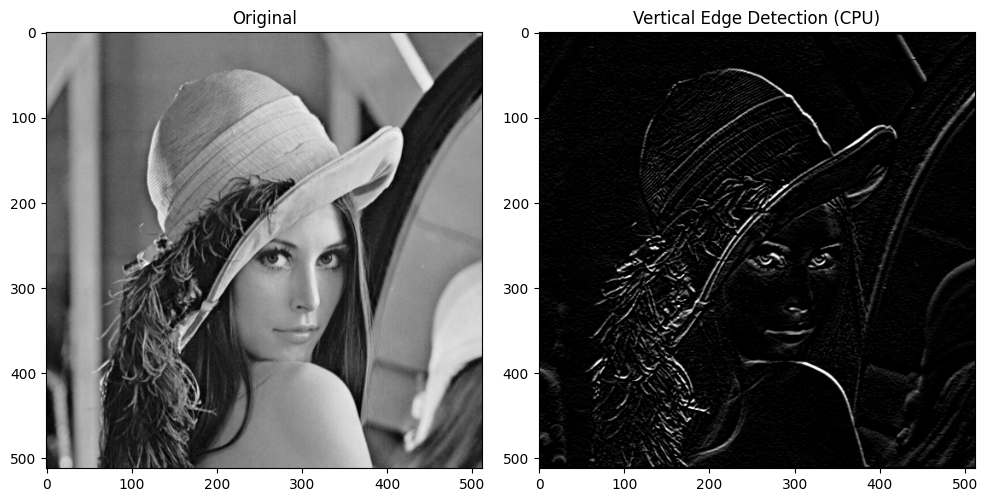

In [59]:
# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_np, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Vertical Edge Detection (CPU)")
plt.imshow(result_cpu, cmap='gray')
plt.tight_layout()
plt.show()

### GPU Implementation

Now, let's implement the same filter on the GPU using CUDA through CuPy.

First, we need to write a CUDA kernel for the convolution operation.

In [60]:
# %%
if cuda_available:
    # Define the CUDA convolution kernel
    convolution_kernel = cp.RawKernel(r'''
    extern "C" __global__
    void conv2d(const float* image, const float* kernel, float* output, 
                int img_h, int img_w, int k_h, int k_w) {
        // Get thread indices (pixel coordinates)
        // @TODO
        int x = blockDim.x * blockIdx.x + ...;
        int y = blockDim.y * blockIdx.y + ...;
        
        // Calculate padding
        int pad_h = k_h / 2;
        int pad_w = k_w / 2;
        
        // Boundary check
        if (x >= img_w || y >= img_h) return;
        
        // Apply convolution
        float sum = 0.0f;
        for (int i = 0; i < k_h; ++i) {
            for (int j = 0; j < k_w; ++j) {
                // Calculate indices with padding
                int xi = x + j;
                int yi = y + i;
                // @TODO
                // Calculate input index with padding
                int input_idx = (... * (img_w + 2 * pad_w)) + ...;
                // @TODO
                // Calculate kernel index
                int kernel_idx = i * ... + j;
                
                // Apply kernel
                // @TODO
                sum += ...[input_idx] * ...[kernel_idx];
            }
        }
        
        // Write result to output
        output[y * img_w + x] = sum;
    }
    ''', 'conv2d')
    
    print("CUDA kernel successfully defined.")
else:
    print("CUDA not available. Skipping kernel definition.")

CUDA kernel successfully defined.


In [61]:
# %%
# Function to apply convolution on GPU
def convolve_gpu(image_np, kernel_np):
    """
    Apply convolution to an image using GPU (CuPy).
    
    Args:
        image_np: 2D NumPy array
        kernel_np: 2D NumPy array
    
    Returns:
        Convolved image as NumPy array
    """
    if not cuda_available:
        print("CUDA not available. Falling back to CPU implementation.")
        return convolve_cpu(image_np, kernel_np)
    
    # Get dimensions
    img_h, img_w = image_np.shape
    k_h, k_w = kernel_np.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Transfer data to GPU
    image_gpu = cp.asarray(image_np)
    kernel_gpu = cp.asarray(kernel_np)
    output_gpu = cp.zeros_like(image_gpu)
    
    # Pad the image
    padded_image = cp.pad(image_gpu, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    
    # Set up CUDA execution configuration
    block_size = (16, 16)
    grid_size = (
        (img_w + block_size[0] - 1) // block_size[0],
        (img_h + block_size[1] - 1) // block_size[1]
    )
    
    # Launch CUDA kernel
    convolution_kernel(
        grid_size, block_size,
        (padded_image.ravel(), kernel_gpu.ravel(), output_gpu.ravel(),
         img_h, img_w, k_h, k_w)
    )
    
    # Transfer result back to CPU
    output_np = cp.asnumpy(output_gpu)
    
    return output_np

GPU convolution time: 0.0170 seconds
Speedup: 64.06x


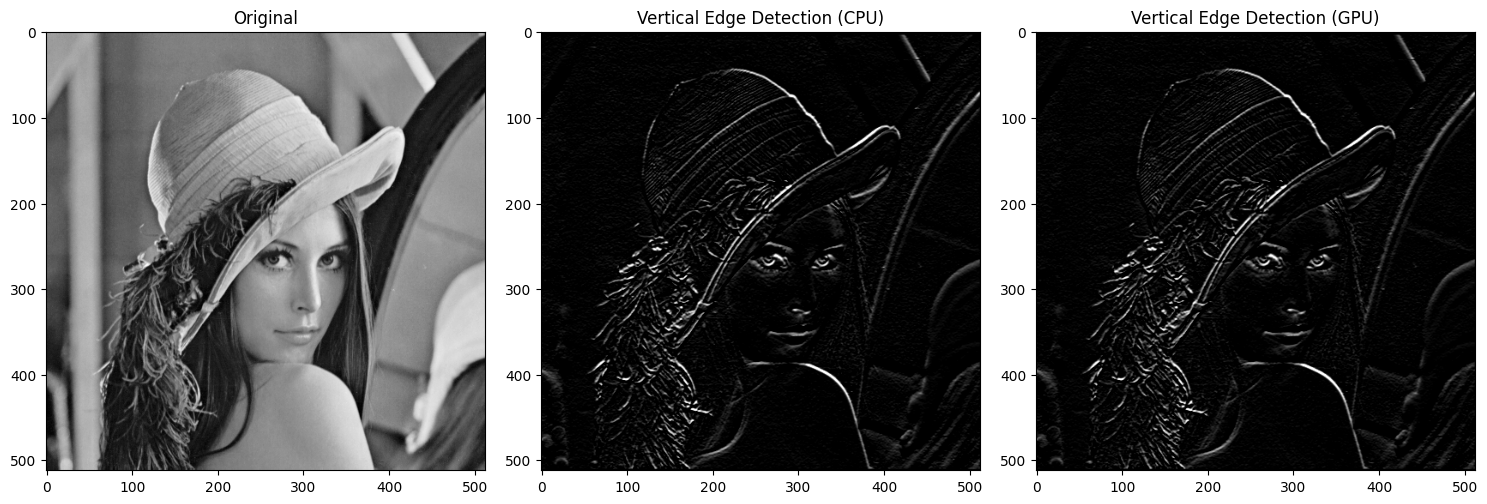

In [62]:
# Test GPU convolution with our Sobel filter
if cuda_available:
    start_time = time.time()
    result_gpu = convolve_gpu(image_np, sobel_v)
    gpu_time = time.time() - start_time
    print(f"GPU convolution time: {gpu_time:.4f} seconds")
    
    if 'cpu_time' in locals():
        print(f"Speedup: {cpu_time / gpu_time:.2f}x")
    
    # Normalize for display
    result_gpu = np.clip(result_gpu, 0, 1)
    
    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image_np, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Vertical Edge Detection (CPU)")
    plt.imshow(result_cpu, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Vertical Edge Detection (GPU)")
    plt.imshow(result_gpu, cmap='gray')
    
    plt.tight_layout()
    plt.show()
else:
    print("CUDA not available. Skipping GPU convolution test.")

## Part 3: Data Transfer Between CPU and GPU

Before we expand to more filters, let's understand how data is transferred between CPU and GPU memory. CuPy provides a simple interface for this.

In [63]:
# %%
# Create NumPy arrays on CPU
cpu_array = np.arange(10, dtype=np.float32)
print("CPU array (NumPy):", cpu_array)

CPU array (NumPy): [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [64]:
# Transfer to GPU using CuPy
if cuda_available:
    gpu_array = cp.asarray(cpu_array)
    print("GPU array (CuPy):", gpu_array)
    
    # Modify on GPU
    gpu_array = gpu_array * 2
    print("Modified GPU array:", gpu_array)
    
    # Transfer back to CPU
    cpu_result = cp.asnumpy(gpu_array)
    print("Result transferred back to CPU:", cpu_result)
else:
    print("CUDA not available. Skipping GPU operations.")

GPU array (CuPy): [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Modified GPU array: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Result transferred back to CPU: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


## Part 4: Exploring Different Convolutional Filters

Now that we've seen how to implement a basic edge detection filter, let's expand our toolkit to include several common image processing filters.

Common image filters include:

1. **Gaussian Blur**: Smooths an image by reducing noise and detail
2. **Sobel**: Detects edges by approximating image gradients
3. **Sharpen**: Enhances edges and details in an image
4. **Emboss**: Creates a 3D effect by highlighting edges

In [65]:
# %%
# Define various image filters
filters = {
    "Edge Detection (Vertical Sobel)": np.array([
        # @TODO
        ...
    ], dtype=np.float32),
    
    "Edge Detection (Horizontal Sobel)": np.array([
        # @TODO
        ...
    ], dtype=np.float32),
    
    "Sharpen": np.array([
        # @TODO
        ...
    ], dtype=np.float32),
    
    "Gaussian Blur": np.array([
        # @TODO
        ...
    ], dtype=np.float32),
    
    "Box Blur": np.array([
        # @TODO
        ...
    ], dtype=np.float32),
    
    "Emboss": np.array([
        [-2, -1, 0],
        [-1,  1, 1],
        [ 0,  1, 2]
    ], dtype=np.float32)
}

In [ ]:
# Display the defined filters
for name, kernel in filters.items():
    print(f"{name}:")
    print(kernel)
    print()

Let's apply all these filters to our image using both CPU and GPU implementations and compare the results.

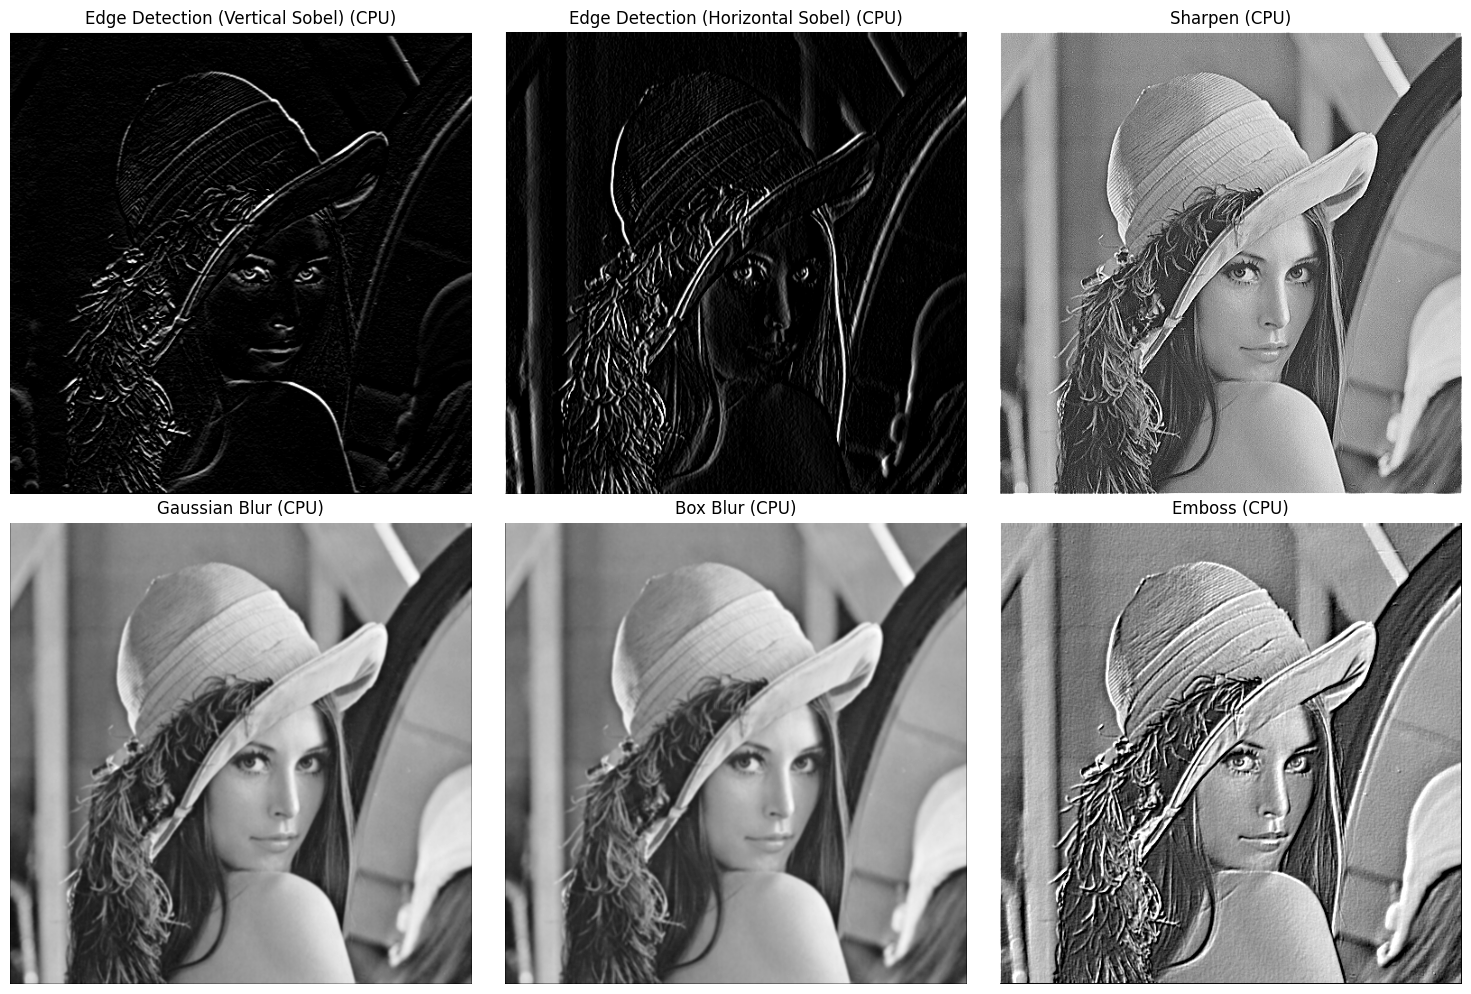

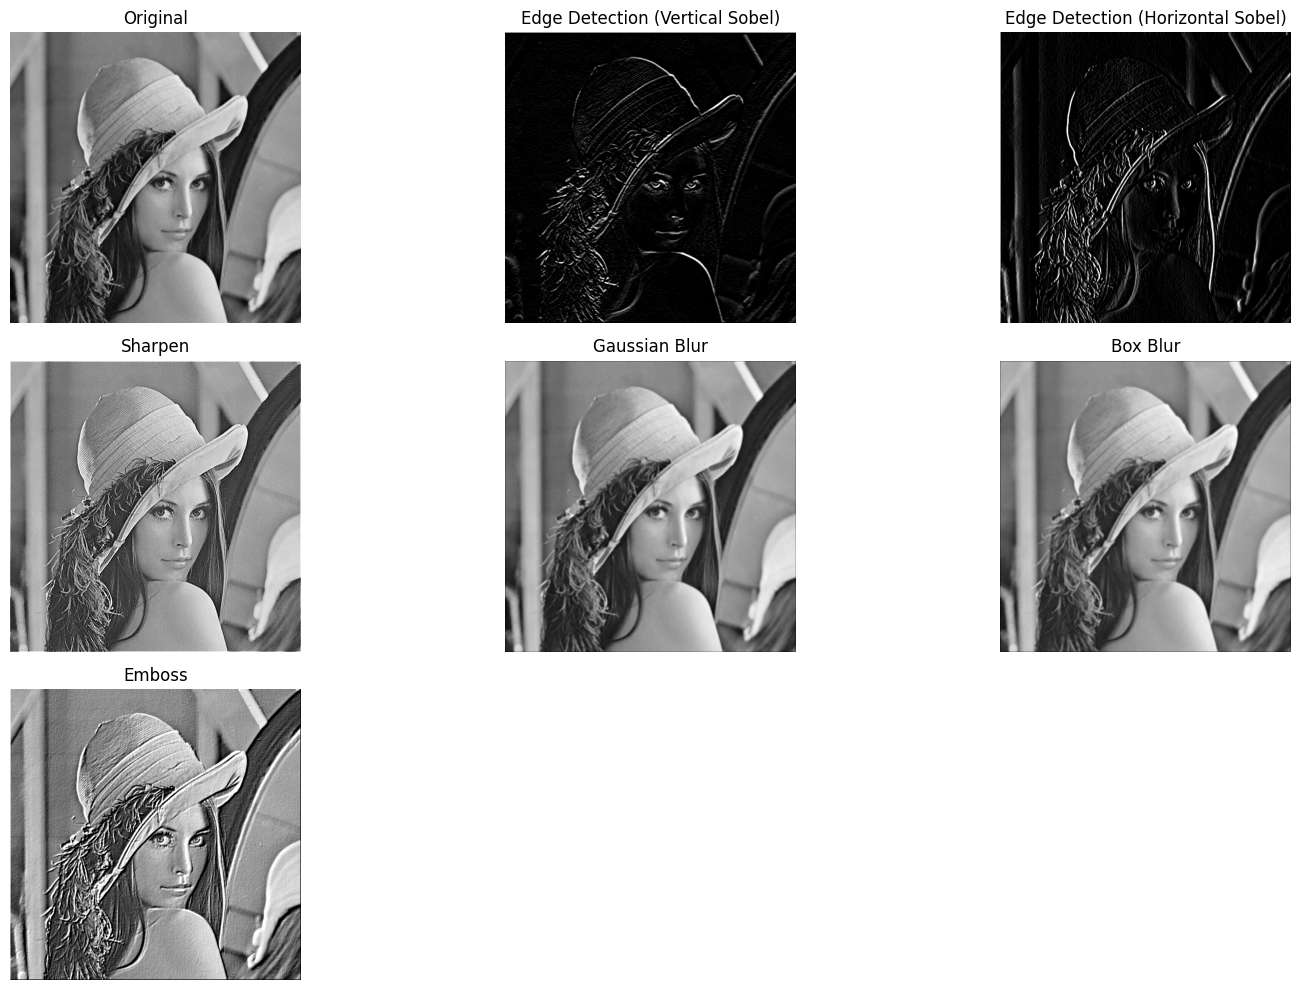

In [67]:
# %%
# Apply all filters using CPU
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, kernel) in enumerate(filters.items()):
    # Apply filter using CPU
    result = convolve_cpu(image_np, kernel)
    
    # Normalize for display
    result = np.clip(result, 0, 1)
    
    # Display result
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(f"{name} (CPU)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# %%
# Apply all filters using GPU
if cuda_available:
    # Apply all filters
    plt.figure(figsize=(15, 10))
    
    # Display original image
    plt.subplot(3, 3, 1)
    plt.title("Original")
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')
    
    # Apply each filter
    for i, (name, kernel) in enumerate(filters.items(), 2):
        result = convolve_gpu(image_np, kernel)
        
        # Normalize for display
        result = np.clip(result, 0, 1)
        
        # Display result
        plt.subplot(3, 3, i)
        plt.title(name)
        plt.imshow(result, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("CUDA not available. Skipping GPU filter application.")



## Part 5: Comparing CPU and GPU Performance

Let's directly compare the performance of CPU and GPU implementations across different image sizes to better understand the performance advantages of CUDA.

Image size: 128x128
  CPU time: 0.0704 seconds
  GPU time: 0.0004 seconds
  Speedup: 167.57x
Image size: 256x256
  CPU time: 0.2586 seconds
  GPU time: 0.0005 seconds
  Speedup: 539.82x
Image size: 512x512
  CPU time: 1.0552 seconds
  GPU time: 0.0007 seconds
  Speedup: 1547.50x
Image size: 1024x1024
  CPU time: 4.2793 seconds
  GPU time: 0.0017 seconds
  Speedup: 2584.05x


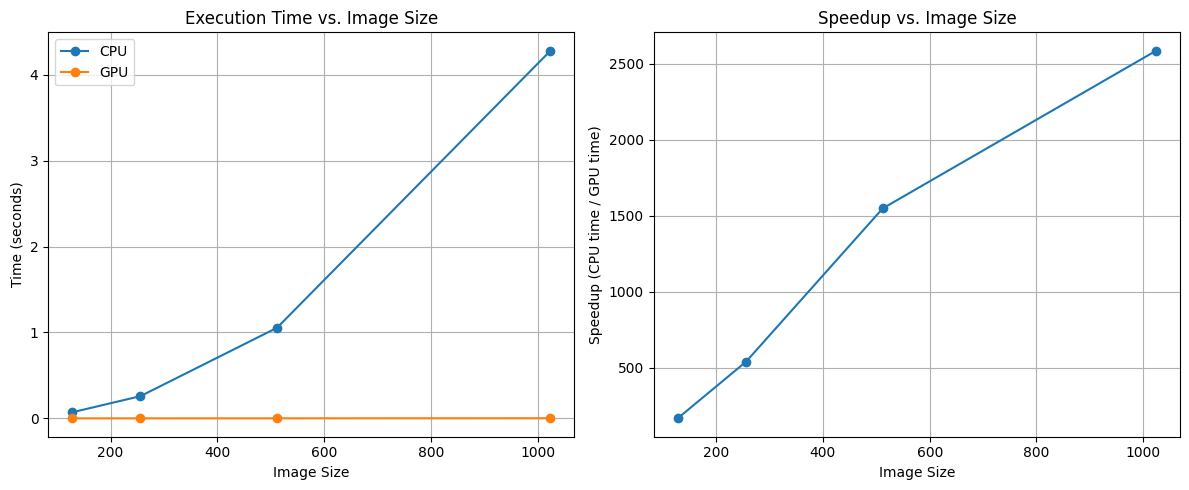

In [68]:
# %%
if cuda_available:
    # Benchmark different image sizes
    sizes = [128, 256, 512, 1024]
    cpu_times = []
    gpu_times = []
    speedups = []
    
    kernel = filters["Edge Detection (Vertical Sobel)"]
    
    for size in sizes:
        # Create a synthetic image
        test_image = np.random.rand(size, size).astype(np.float32)
        
        # CPU timing
        start_time = time.time()
        # @TODO convolve_cpu
        _ = ...
        cpu_time = time.time() - start_time
        cpu_times.append(cpu_time)
        
        # GPU timing
        start_time = time.time()
        # @TODO convolve_gpu
        _ = ...
        gpu_time = time.time() - start_time
        gpu_times.append(gpu_time)
        
        speedups.append(cpu_time / gpu_time)
        
        print(f"Image size: {size}x{size}")
        print(f"  CPU time: {cpu_time:.4f} seconds")
        print(f"  GPU time: {gpu_time:.4f} seconds")
        print(f"  Speedup: {cpu_time / gpu_time:.2f}x")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(sizes, cpu_times, 'o-', label='CPU')
    plt.plot(sizes, gpu_times, 'o-', label='GPU')
    plt.xlabel('Image Size')
    plt.ylabel('Time (seconds)')
    plt.title('Execution Time vs. Image Size')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(sizes, speedups, 'o-')
    plt.xlabel('Image Size')
    plt.ylabel('Speedup (CPU time / GPU time)')
    plt.title('Speedup vs. Image Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("CUDA not available. Skipping performance benchmarking.")